In [ ]:
import types

ARGS = types.SimpleNamespace()
ARGS.species = "erato"
ARGS.color = "color_3"
ARGS.wing = "forewings"
ARGS.genome_folder = "/local/scratch/carlyn.1/dna/vcfs/processed/genome"
ARGS.phenotype_folder = "/local/scratch/carlyn.1/dna/colors/processed"
#ARGS.genome_folder = "/local/scratch/david/geno-pheno-data/dna/processed/genome"
#ARGS.phenotype_folder = "/local/scratch/david/geno-pheno-data/colors/processed/"
ARGS.out_dims = 1
ARGS.out_dims_start_idx = 0
ARGS.split_data_folder = "/home/carlyn.1/dna-trait-analysis/data"
ARGS.top_k_chromosome_training_path = "/home/carlyn.1/dna-trait-analysis/plot_results/pvalue_erato_forewings_color_3/top_k_snps_erato_forewings_color_3.npy"

In [2]:
import copy
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

import numpy as np

from gtp.dataloading.tools import (
    load_chromosome_data,
    split_data_by_file,
)

def load_data(args):
    camids_aligned, genotype_data_aligned, phenotype_data_aligned = (
        load_chromosome_data(
            args.genome_folder,
            args.phenotype_folder,
            args.species,
            args.wing,
            args.color,
            args.chromosome,
        )
    )

    phenotype_data_aligned = phenotype_data_aligned[
        :, args.out_dims_start_idx : args.out_dims_start_idx + args.out_dims
    ]

    train_split, val_split, test_split = split_data_by_file(
        genotype_data_aligned,
        phenotype_data_aligned,
        camids_aligned,
        args.split_data_folder,
        args.species,
    )

    return train_split, val_split, test_split

def load_one(args, chromosome, snp_idx, idx):
    cur_args = copy.deepcopy(args)
    cur_args.chromosome = chromosome
    train_data, val_data, test_data = load_data(cur_args)
    snp_idx = np.sort(snp_idx).astype(np.int64)
    train_data[0] = train_data[0][:, snp_idx]
    val_data[0] = val_data[0][:, snp_idx]
    test_data[0] = test_data[0][:, snp_idx]
    return (
        idx,
        train_data,
        val_data,
        test_data,
        snp_idx
    )

futures = []
pool = ThreadPoolExecutor(4)
final_train_data = None
final_val_data = None
final_test_data = None
final_snps = []
data = np.load(ARGS.top_k_chromosome_training_path, allow_pickle=True)
test_snp_selections = data.item()["test"]
for idx, snp_idx in tqdm(enumerate(test_snp_selections), desc="loading top snps from chromosome"):
    future = pool.submit(load_one, ARGS, idx + 1, snp_idx[:100], idx)
    futures.append(future)

total = 0
all_data = []
for future in as_completed(futures):
    proc_idx, train_data, val_data, test_data, snp_idx,  = future.result()
    all_data.append([proc_idx, train_data, val_data, test_data, snp_idx])
    total += 1
    print(f"Completed loading on chromosome: {proc_idx+1}: ({total}/21)")

for proc_idx, train_data, val_data, test_data, snp_idx in sorted(all_data, key=lambda x: int(x[0])):
    print(proc_idx)
    final_snps.extend([f"C_{proc_idx+1}_SNP_{si}" for si in snp_idx])
    if final_train_data is None:
        final_train_data = train_data
        final_val_data = val_data
        final_test_data = test_data
    else:
        final_train_data[0] = np.concatenate(
            (final_train_data[0], train_data[0]), axis=1
        )
        final_val_data[0] = np.concatenate(
            (final_val_data[0], val_data[0]), axis=1
        )
        final_test_data[0] = np.concatenate(
            (final_test_data[0], test_data[0]), axis=1
        )
        assert (train_data[1] == final_train_data[1]).all()
        assert (val_data[1] == final_val_data[1]).all()
        assert (test_data[1] == final_test_data[1]).all()

loading top snps from chromosome: 21it [00:00, 3928.83it/s]


load_phenotype_data exe time: 00:00:00
load_phenotype_data exe time: 00:00:00
load_phenotype_data exe time: 00:00:00
load_phenotype_data exe time: 00:00:00
collect_chromosome exe time: 00:00:16
align_genotype_and_phenotype_data exe time: 00:00:05
load_chromosome_data exe time: 00:00:22
collect_chromosome exe time: 00:00:27
collect_chromosome exe time: 00:00:27
Completed loading on chromosome: 3: (1/21)
load_phenotype_data exe time: 00:00:00
align_genotype_and_phenotype_data exe time: 00:00:00
load_chromosome_data exe time: 00:00:27
Completed loading on chromosome: 2: (2/21)
load_phenotype_data exe time: 00:00:00
align_genotype_and_phenotype_data exe time: 00:00:05
load_chromosome_data exe time: 00:00:33
collect_chromosome exe time: 00:00:41
Completed loading on chromosome: 1: (3/21)
load_phenotype_data exe time: 00:00:00
align_genotype_and_phenotype_data exe time: 00:00:04
load_chromosome_data exe time: 00:00:45
Completed loading on chromosome: 4: (4/21)
load_phenotype_data exe time: 0

## Transform for bitepi

In [3]:
import pandas as pd

"""
"0|0": [1, 0, 0], => 0
"1|0": [0, 1, 0], => 1
"0|1": [0, 1, 0], => 1
"1|1": [0, 0, 1], => 2
"""

tx, ty = final_train_data
tx.shape

vx, vy = final_val_data
vx.shape

sample_names = [[f"S{i}", 1] for i in range(tx.shape[0])] + [[f"S{i+tx.shape[0]}", 0] for i in range(vx.shape[0])]
snp_names = final_snps
sample_names

sample_snp_matrix_t = (tx * [0, 1, 2]).sum(-1)
sample_snp_matrix_v = (vx * [0, 1, 2]).sum(-1)
sample_snp_matrix = np.concatenate((sample_snp_matrix_t.T, sample_snp_matrix_v.T), axis=1)

data = np.concatenate((np.array(snp_names)[:, np.newaxis], sample_snp_matrix), axis=1)
sample_array = np.array(sample_names)
df = pd.DataFrame(data, columns=["SNP"] + sample_array[:, 0].tolist())
df.head(4)

,SNP,S0,S1,S2,S3,S4,S5,S6,S7,S8,...,S421,S422,S423,S424,S425,S426,S427,S428,S429,S430
0,C_1_SNP_307,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C_1_SNP_10516,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,C_1_SNP_10519,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,C_1_SNP_21689,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
geno_matrix = np.concatenate((df.columns.to_numpy()[np.newaxis, :], df.to_numpy()), axis=0)
geno_matrix = geno_matrix.tolist()
for i in range(len(geno_matrix)):
    for j in range(len(geno_matrix[i])):
        if i == 0: continue
        if j == 0: continue
        geno_matrix[i][j] = int(geno_matrix[i][j])

In [ ]:
from tqdm import tqdm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sma

from gtp.tools import calc_pvalue_linear

y = ty[:, 0]

fo_pvals = []
fo_r2 = []
fo_val_rmse = []
for i in tqdm(range(sample_snp_matrix_t.shape[1]), desc="Calculating first-order scores"):
    if len(np.unique(sample_snp_matrix_t[:, i], return_counts=True)[0]) <= 1 :
        fo_pvals.append(1.0)
        fo_r2.append(0)
        fo_val_rmse.append(999)
        continue
    X = sample_snp_matrix_t[:, i].reshape(-1, 1)
    #model = LinearRegression().fit(X, y)
    X = sma.add_constant(X)
    m = sma.OLS(y, X)
    m2 = m.fit()
    fo_pvals.append(m2.pvalues[-1])
    fo_r2.append(m2.rsquared)
    Xv = sample_snp_matrix_v[:, i].reshape(-1, 1)
    Xv = np.concatenate((np.ones_like(Xv), Xv), axis=1)
    yv = vy[:, 0]
    predictions = m2.predict(Xv)
    rsme = np.sqrt(((predictions - yv) ** 2).sum() / (len(predictions)-2))
    fo_val_rmse.append(rsme)
    #score = model.score(Xv, yv)
    #first_order_scores.append(score)
    #if score > best_fo_score:
    #    best_fo_score = score
    #    print(f"Best score of: {score} | By: {i}")
    

Calculating first-order scores: 100%|██████████| 2100/2100 [00:00<00:00, 2515.54it/s]


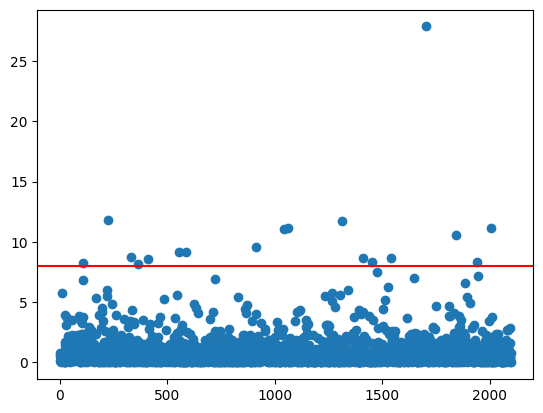

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(np.arange(len(fo_pvals)), -np.log10(fo_pvals))
plt.axhline(y=-np.log10(1e-8), color='r', linestyle='-')
plt.show()

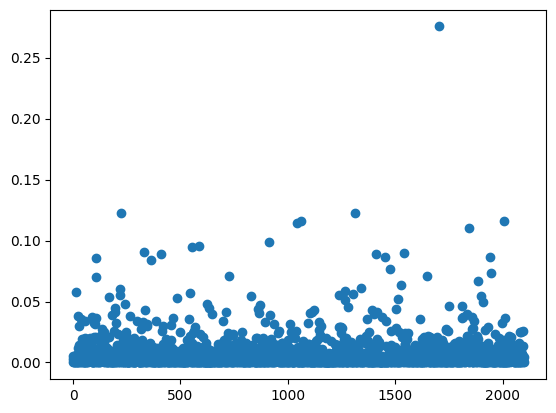

In [7]:
plt.figure()
plt.scatter(np.arange(len(fo_r2)), fo_r2)
plt.show()

In [8]:
import itertools as it
from sklearn.linear_model import LinearRegression
import statsmodels.api as sma


interactions = list(it.combinations(range(sample_snp_matrix_t.shape[1]), 2))
so_pvals = []
so_r2 = []
so_val_rmse = []
so_best_r2 = 0
for i, j in tqdm(interactions, desc="Calculating interactions"):
    if len(np.unique(sample_snp_matrix_t[:, i], return_counts=True)[0]) <= 1 or len(np.unique(sample_snp_matrix_t[:, j], return_counts=True)[0]) <= 1:
        so_pvals.append(1.0)
        so_r2.append(0)
        so_val_rmse.append(999)
        continue

    X = np.concatenate((sample_snp_matrix_t[:, i:i+1], sample_snp_matrix_t[:, j:j+1]), axis=1)
    X = sma.add_constant(X)
    m = sma.OLS(y, X)
    m2 = m.fit()
    so_pvals.append(m2.pvalues[1:])
    so_r2.append(m2.rsquared)
    Xv = sample_snp_matrix_v[:, i].reshape(-1, 1)
    Xv = np.concatenate((sample_snp_matrix_v[:, i:i+1], sample_snp_matrix_v[:, j:j+1]), axis=1)
    Xv = np.concatenate((np.ones_like(Xv[:, :1]), Xv), axis=1)
    yv = vy[:, 0]
    predictions = m2.predict(Xv)
    rsme = np.sqrt(((predictions - yv) ** 2).sum() / (len(predictions)-2))
    so_val_rmse.append(rsme)
    
    if so_best_r2 < rsme:
        so_best_r2 = rsme
        print(f"Best RMSE: {rsme} from ({i}, {j})")
    #m = sma.OLS(y, X)
    #m2 = m.fit()
    #print(m2.pvalues)
    #break
    #model = LinearRegression().fit(X, y)
    #score = model.score(Xv, vy)
    #second_order_scores.append(score)
    #score_diff = score - first_order_scores[i] - first_order_scores[j]
    #second_order_score_diffs.append(score_diff)
    #if score > best_score:
    #    best_score = score
    #    print(f"Best score of: {score} | By: ({i}, {j}) | Diff: {score} - {first_order_scores[i]} - {first_order_scores[j]} = {score_diff}")
    #if abs(best_diff) < abs(score_diff):
    #    best_diff = score_diff
    #    print(f"Best diff: {score_diff} = {score} - {first_order_scores[i]} - {first_order_scores[j]} | By: ({i}, {j})")
    #result = stats.linregress(X, y)
    #pval = result.pvalue
    #second_order_pvals.append(pval)

#result = stats.linregress(snp_categories, y)
#pval = result.pvalue

Calculating interactions:   0%|          | 442/2203950 [00:00<16:30, 2224.57it/s]

Best RMSE: 22.66162389108675 from (0, 1)
Best RMSE: 22.787009200902393 from (0, 3)
Best RMSE: 22.789529929611568 from (0, 4)
Best RMSE: 22.993695628991627 from (0, 8)
Best RMSE: 23.014637092873176 from (0, 11)
Best RMSE: 23.021041947384596 from (0, 23)
Best RMSE: 23.7428384215544 from (0, 29)
Best RMSE: 23.81477513773475 from (0, 167)
Best RMSE: 24.568767182826722 from (0, 335)


Calculating interactions:   0%|          | 1370/2203950 [00:00<15:55, 2306.36it/s]

Best RMSE: 26.304011396202007 from (0, 1060)


Calculating interactions:   0%|          | 9673/2203950 [00:04<16:47, 2177.54it/s]

Best RMSE: 26.372203883829496 from (4, 1060)


Calculating interactions:   1%|          | 11768/2203950 [00:05<16:11, 2255.79it/s]

Best RMSE: 26.764062982037885 from (5, 1060)


Calculating interactions:   3%|▎         | 61888/2203950 [00:25<15:26, 2312.15it/s]

Best RMSE: 27.068750313328856 from (29, 1060)


Calculating interactions:   5%|▌         | 111245/2203950 [00:47<15:06, 2307.82it/s]

Best RMSE: 27.31899115053917 from (53, 1060)


Calculating interactions:  41%|████▏     | 912796/2203950 [06:32<09:16, 2321.71it/s]

Best RMSE: 27.322639554925015 from (492, 1060)


Calculating interactions:  47%|████▋     | 1045694/2203950 [07:28<08:28, 2279.48it/s]

Best RMSE: 27.33039612113877 from (577, 1060)


Calculating interactions:  53%|█████▎    | 1177347/2203950 [08:25<07:19, 2338.36it/s]

Best RMSE: 28.14172167420317 from (666, 1060)


Calculating interactions:  76%|███████▌  | 1664131/2203950 [11:54<03:52, 2323.79it/s]

Best RMSE: 28.271894703077493 from (1060, 1151)


Calculating interactions: 100%|██████████| 2203950/2203950 [15:45<00:00, 2330.39it/s]


In [11]:
diffs = []
for k, (i, j) in tqdm(enumerate(interactions), desc="Calculating interactions"):
    x = so_r2[k]
    x1 = fo_r2[i]
    x2 = fo_r2[j]
    diffs.append(x - (x1+x2))
    

Calculating interactions: 2203950it [00:01, 2162189.87it/s]


In [14]:
sorted_diffs = sorted(list(zip(diffs, interactions)), key=lambda x: float(x[0]), reverse=True)

In [22]:
flatten_diffs = [[x[0], x[1][0], x[1][1]] for x in sorted_diffs]
flatten_diffs[:30]

[[np.float64(0.030305991915945518), 1744, 1745],
 [np.float64(0.028935914836773158), 1333, 1334],
 [np.float64(0.013469845107574097), 1265, 1280],
 [np.float64(0.012637068098136028), 1266, 1415],
 [np.float64(0.01216022038287401), 1440, 1453],
 [np.float64(0.012137940644927903), 329, 1929],
 [np.float64(0.011034033790460418), 1705, 1971],
 [np.float64(0.010914434385382643), 222, 1918],
 [np.float64(0.010821242814578524), 502, 538],
 [np.float64(0.010792493186719931), 195, 1813],
 [np.float64(0.010487564815601536), 865, 1254],
 [np.float64(0.0102619080842129), 222, 1812],
 [np.float64(0.010112346730352217), 546, 1453],
 [np.float64(0.010062191881205718), 329, 1864],
 [np.float64(0.00993423599750376), 108, 223],
 [np.float64(0.009925366119072132), 12, 697],
 [np.float64(0.0098620999009299), 222, 1017],
 [np.float64(0.009847100190652824), 385, 1453],
 [np.float64(0.009658686212542622), 108, 743],
 [np.float64(0.009597225415551303), 98, 201],
 [np.float64(0.009589360004916059), 1813, 1864]

In [21]:
import pandas as pd
df = pd.DataFrame(flatten_diffs)
df.head(5)
df.to_csv("/local/scratch/carlyn.1/tmp/r2_diffs.csv")

In [23]:
tp_to_k_map = {(i, j) : k for k, (i, j) in enumerate(interactions)}

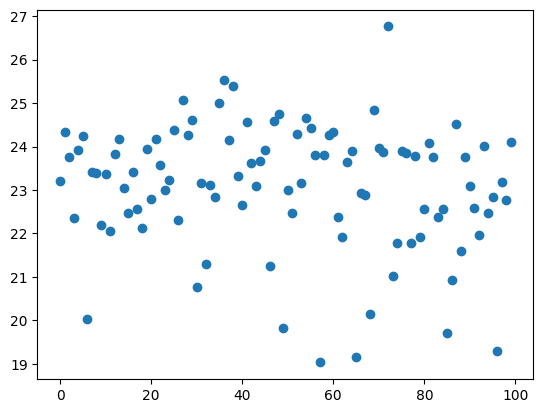

In [26]:
import matplotlib.pyplot as plt

sorted_val_rmse = []
for _, (i, j) in sorted_diffs:
    k = tp_to_k_map[(i, j)]
    sorted_val_rmse.append(so_val_rmse[k])
    
plt.figure()
plt.scatter(np.arange(100), sorted_val_rmse[:100])
plt.show()


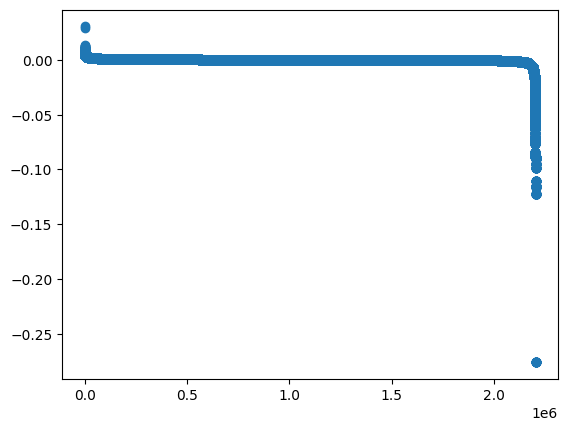

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(np.arange(len(sorted_diffs)), [x[0] for x in sorted_diffs])
plt.show()

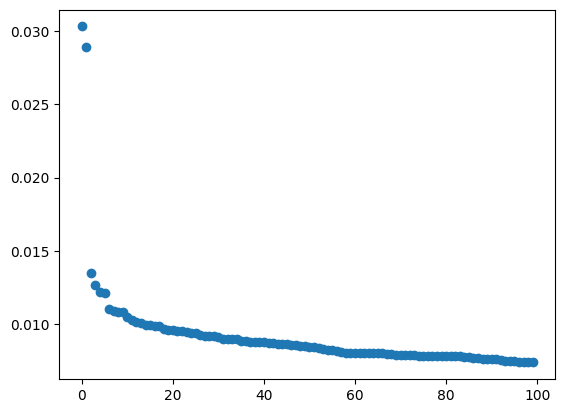

In [17]:
v=100
plt.figure()
plt.scatter(np.arange(v), [x[0] for x in sorted_diffs[:v]])
plt.show()

In [10]:
from scipy import stats

# I want to find pairs of snps where their combined interaction is more expressive than the sum of their interactions
pairs_of_interests = [(idx, i, j) for idx, (i, j) in enumerate(interactions) if second_order_scores[idx] > sum([first_order_scores[i], first_order_scores[j]]) and second_order_scores[idx] > 0]
print(len(pairs_of_interests))
print(len(interactions))
t = np.array(pairs_of_interests)
idx_counts = np.unique(t[:, 1:], return_counts=True)[1]
top = np.argsort(idx_counts)[1]
top


NameError: name 'second_order_scores' is not defined

In [ ]:
# Based on logging the best scores. it seems position 1314 has strong interaction results
poi = top
print(f"{poi} 1st order score: {first_order_scores[poi]}")

poi_interactions = [(idx, inter) for idx, inter in enumerate(interactions) if poi in inter]
diffs = [second_order_score_diffs[idx] for idx, _ in poi_interactions]
scores = [second_order_scores[idx] for idx, _ in poi_interactions]

1461 1st order score: -0.027291598642796178


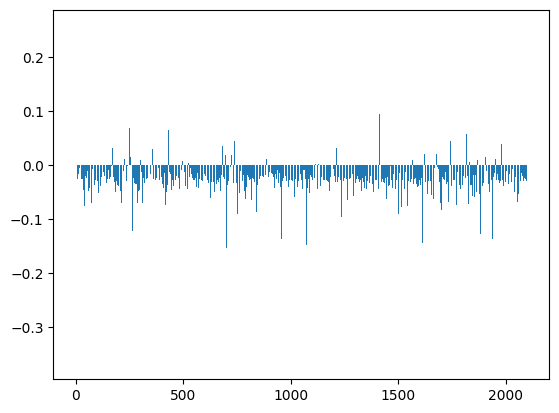

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(np.arange(len(scores)), scores)
plt.show()

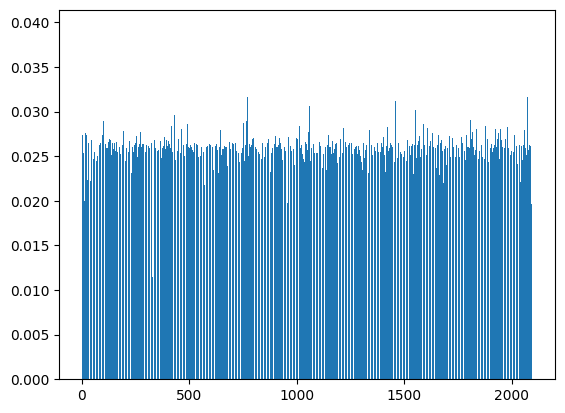

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(np.arange(len(diffs)), diffs)
plt.show()

In [ ]:
s_data = sorted(list(zip(poi_interactions, scores)), key=lambda x: x[1], reverse=True)
print(s_data[0][0])
print(first_order_scores[568], first_order_scores[1314], second_order_scores[s_data[0][0][0]])

(1031949, (568, 1314))
0.22176417902885848 0.2580732270474918 0.4688488475102143


In [ ]:
from sklearn.linear_model import LinearRegression
from epistasis.models import EpistasisLinearRegression


X = np.array(geno_matrix).T[1:, 1:].astype(np.float32)
y = np.concatenate((ty, vy), axis=0)[:, 0].astype(np.float32)
y.shape

model = LinearRegression().fit(X, y)
model.score(X, y)
epi_vals = np.reshape(model.coef_, (-1,))
epi_vals


array([-0.01229471,  0.0491806 , -0.08622867, ..., -0.00735176,
       -0.00792222, -0.04456605], dtype=float32)

In [ ]:
#import itertools as it
#from epistasis.pyplot import plot_coefs
#
#sites = [[i] for i in range(len(epi_vals))]
#
#plot_coefs(sites=sites, values=epi_vals.tolist(), figsize=(3,5))

1


In [ ]:
v, c = np.unique(sample_snp_matrix_t[:, 1200], return_counts=True)
print(v, c)
m, _ = sorted(list(zip(v, c)), key=lambda x: x[1], reverse=True)[0]


[0 1 2] [163 190  31]


In [ ]:
snp_to_letter_map = {
    0: "C",
    1: "B",
    2: "A",
}

sample_snp_matrix_t.shape
str_data = []
for i, row in enumerate(sample_snp_matrix_t):
    genome = ""
    for j, snp in enumerate(row):
        snp_letter = ""
        if snp == 0:
            snp_letter = "C"
        elif snp == 1:
            snp_letter = "B"
        elif snp == 2:
            snp_letter = "A"
        genome += snp_letter
    str_data.append(genome)
    
for j in range(sample_snp_matrix_t.shape[1]):
    v, c = np.unique(sample_snp_matrix_t[:, j], return_counts=True)
    m, _ = sorted(list(zip(v, c)), key=lambda x: x[1], reverse=True)[0]
wildtype = ""
    
str_data[0]
ty[:, 0]

array([-2.09701920e+01, -7.89356361e+00, -1.00907009e+01, -1.10824068e+01,
       -9.46492963e+00, -1.28285819e+01, -7.47989196e+00, -1.77208728e+01,
       -5.43471884e+00, -9.12793016e+00, -5.06690770e+00, -6.34825829e+00,
       -1.27139236e+01, -6.58376143e+00, -9.83880759e+00, -6.56328420e+00,
       -7.45363276e+00,  8.59490259e+01,  8.77756886e+01,  9.10299043e+01,
        9.29954159e+01, -7.74200301e+00, -1.67542728e+01,  1.67196193e+00,
       -4.08663046e+00, -9.51606354e+00,  2.56632486e+00,  1.48065801e+01,
        1.21078778e+01,  7.67925748e+00,  4.01034928e+00,  4.25380891e+00,
        1.77660262e+01, -3.78633107e+00, -1.14872046e+01,  1.01344013e+01,
        1.31232163e+01, -1.06387594e+00, -1.03521745e+01,  3.79353978e+00,
       -5.45461353e-01, -3.58557603e+00, -5.11636026e+00,  6.66263875e+01,
       -1.40370617e+01, -1.11398618e+01,  9.03901009e+00, -1.34353969e+01,
       -1.02352907e+01, -1.27606555e+01, -5.08549483e+00, -1.16241740e+01,
       -1.64625197e+01, -

In [ ]:
np

In [ ]:
"".join(["A" for _ in range(len(str_data[0]))])

'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [ ]:
# Import a model and the plotting module
from gpmap import GenotypePhenotypeMap
from epistasis.models import EpistasisLinearRegression
from epistasis.pyplot import plot_coefs

# Genotype-phenotype map data.
wildtype = "AAA"
genotypes = ["ATT", "AAT", "ATA", "TAA", "ATT", "TAT", "TTA", "TTT"]
phenotypes = [0.1, 0.2, 0.4, 0.3, 0.3, 0.6, 0.8, 1.0]

# Create genotype-phenotype map object.
gpm = GenotypePhenotypeMap(wildtype="".join(["A" for _ in range(len(str_data[0]))]),
                           genotypes=str_data,
                           phenotypes=ty[:, 0].tolist())

# Initialize an epistasis model.
model = EpistasisLinearRegression(order=3)

# Add the genotype phenotype map.
model.add_gpm(gpm)

# Fit model to given genotype-phenotype map.
model.fit()

# Plot coefficients (powered by matplotlib).
plot_coefs(model, figsize=(3,5))

/home/carlyn.1/tmp/epistasis/epistasis/matrix.py:13: Warning: Could not load cython extension, "build_model_matrix".
  _warnings.warn('Could not load cython extension, "build_model_matrix".', Warning)


dict_keys([(np.int64(0), 'A'), (np.int64(0), np.str_('B')), (np.int64(1), 'A'), (np.int64(1), np.str_('B')), (np.int64(1), np.str_('C')), (np.int64(2), 'A'), (np.int64(2), np.str_('B')), (np.int64(2), np.str_('C')), (np.int64(3), 'A'), (np.int64(3), np.str_('B')), (np.int64(3), np.str_('C')), (np.int64(4), 'A'), (np.int64(4), np.str_('B')), (np.int64(4), np.str_('C')), (np.int64(5), 'A'), (np.int64(5), np.str_('B')), (np.int64(5), np.str_('C')), (np.int64(6), 'A'), (np.int64(6), np.str_('B')), (np.int64(6), np.str_('C')), (np.int64(7), 'A'), (np.int64(7), np.str_('B')), (np.int64(7), np.str_('C')), (np.int64(8), 'A'), (np.int64(8), np.str_('B')), (np.int64(8), np.str_('C')), (np.int64(9), 'A'), (np.int64(9), np.str_('B')), (np.int64(9), np.str_('C')), (np.int64(10), 'A'), (np.int64(10), np.str_('B')), (np.int64(10), np.str_('C')), (np.int64(11), 'A'), (np.int64(11), np.str_('B')), (np.int64(11), np.str_('C')), (np.int64(12), 'A'), (np.int64(12), np.str_('B')), (np.int64(12), np.str_('C

KeyError: (16, 'C')

In [ ]:
#interactions['ig2'].sort_values(by="IG")